In [ ]:
#@title Setup
import os

# os.chdir(f'/content/OurDDPM')
os.makedirs("checkpoint", exist_ok=True)
os.makedirs("precomputed", exist_ok=True)
os.makedirs("pretrained", exist_ok=True)
os.makedirs("runs", exist_ok=True)
os.makedirs("runs/interpolation", exist_ok=True)

from ourddpm import OurDDPM
from main import dict2namespace
import argparse
import yaml
from PIL import Image
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

device = 'cuda'

%load_ext autoreload
%autoreload 2

In [ ]:
import torch
import pdb
import cv2
import glob
# from google.colab.patches import cv2_imshow
import pickle
import matplotlib.pyplot as plt
from math import sqrt

model_path = os.path.join("pretrained/celeba_hq.ckpt")

exp_dir = f"runs/guided"
os.makedirs(exp_dir, exist_ok=True)


n_step =  999#@param {type: "integer"}
sampling = "ddpm" #@param ["ddpm", "ddim"]
fixed_xt = True #@param {type: "boolean"}
add_var = True #@param {type: "boolean"}
add_var_on = "0-999" #@param {type: "string"}
vis_gen =  True #@param {type: "boolean"}

# torch.cuda.set_device(7)

args_dic = {
    'config': 'celeba.yml', 
    'n_step': int(n_step), 
    'sample_type': sampling, 
    'eta': 0.0,
    'bs_test': 1, 
    'model_path': model_path, 
    'hybrid_noise': 0, 
    'align_face': 0,
    'image_folder': exp_dir,
    'add_var': bool(add_var),
    'add_var_on': add_var_on
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)


if bool(add_var):
    var_scheduler = []
    periods = add_var_on.split(",")
    for period in periods:
        start = int(period.split("-")[0])
        end = int(period.split("-")[1])
        for n in range(start,end):
            var_scheduler.append(n)

In [ ]:
def normalize(img):
    return (img + 1) / 2.0

def fuse_and_display(imgs):
    imgs = [np.array(e) for e in imgs]
    imgs = [normalize(img[0].transpose(1, 2, 0)) for img in imgs]
    display = cv2.hconcat(imgs)
    # display = cv2.cvtColor(display, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(20, 40))
    plt.imshow(display)

def display_img(img):
    img = normalize(img).permute(1, 2, 0)
    plt.figure()
    plt.imshow(img)

In [ ]:
# if "data_list" not in locals():
#     with open("runs/interpolation/data_1.obj","rb") as f:
#         data_list = pickle.load(f)


device = torch.device("cuda:7")
config.device = device
runner = OurDDPM(args, config, device=device)
runner.load_classifier("checkpoint/attr_classifier_4_attrs_40.pt", feature_num=4)

In [ ]:

res_list = []
# for i, s in enumerate([1, 2, 3, 4, 5]):
for i, s in enumerate([-200, -100, 0, 100, 200]):
    print(f"Processing {i}th sample...")

    xt = data_list[3]["xt"]
    noise_traj = torch.tensor(data_list[3]["noise_traj"]).cuda()
    img = runner.guided_generate_ddpm(xt, var_scheduler, runner.classifier, 1, classifier_scale=s, noise_traj=noise_traj)

    res_list.append(img.detach().cpu())
    torch.cuda.empty_cache()

with open("runs/guided/data_smile_1.obj", "wb") as f:
    pickle.dump(res_list, f)

In [ ]:
import torch.nn.functional as F

with open("runs/guided/data_smile_1.obj", "rb") as f:
    results = pickle.load(f)
fuse_and_display(results)
classifier_score = []
for each in results:
    t = (torch.ones(1) * 0).cuda()
    classifier_score.append(F.sigmoid(runner.classifier(each.cuda(), t)[:]))
classifier_score

In [1]:
import torch
import torch.nn.functional as F
a = torch.tensor([1, 2, 3])
b = F.normalize(a)
b

ModuleNotFoundError: No module named 'torch.nn.functionals'

In [8]:
import torch
import os
from models.ddpm.diffusion import DDPM
from main import dict2namespace
import yaml


model_path = os.path.join("pretrained/celeba_hq.ckpt")
exp_dir = "PLACEHOLDER"

def get_scheduler(s):
    scheduler = set()
    periods = s.split(",")
    for p in periods:
        l = int(p.split("-")[0])
        r = int(p.split("-")[1])
        for i in range(l, r):
            scheduler.add(i)
    return scheduler

n_step =  999#@param {type: "integer"}
sampling = "ddpm" #@param ["ddpm", "ddim"]
fixed_xt = True #@param {type: "boolean"}
add_var = True #@param {type: "boolean"}
add_var_on = "0-999" #@param {type: "string"}
vis_gen =  True #@param {type: "boolean"}
guidance_on  = "800-999"

var_scheduler = get_scheduler(add_var_on)
guidance_scheduler = get_scheduler(guidance_on)

args_dic = {
    'config': 'celeba.yml', 
    'n_step': int(n_step), 
    'sample_type': sampling, 
    'eta': 0.0,
    'bs_test': 1, 
    'model_path': model_path, 
    'hybrid_noise': 0, 
    'align_face': 0,
    'image_folder': exp_dir,
    'add_var': bool(add_var),
    'add_var_on': add_var_on,
    'guidance_scheduler': guidance_scheduler
    }
args = dict2namespace(args_dic)

with open(os.path.join('configs', args.config), 'r') as f:
    config_dic = yaml.safe_load(f)
config = dict2namespace(config_dic)
device = torch.device("cuda")
config.device = device

ckpt_dir = "checkpoint"
restore_ckpt_dir = os.path.join(ckpt_dir, f"epoch_{180}.pt")
restoration = DDPM(config)
ckpt = torch.load(restore_ckpt_dir)
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in ckpt.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

restoration.load_state_dict(new_state_dict)
restoration.conv_out

Conv2d(128, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [10]:
import clip
import torch
from PIL import Image
import numpy as np
from pytorch_grad_cam import GradCAM
import torch.nn.functional as F

clip_model, preprocess = clip.load("RN101", device="cuda")
target = "woman with blonde hair"
target_text = clip.tokenize([target]).cuda()
target_text = clip_model.encode_text(target_text)
img = Image.open("test.png")
arr = preprocess(img).unsqueeze(0).cuda()
print(arr.dtype)

class CLIPTarget():
    def __init__(self, target_text, clip_reference_text=None):
        self.clip_target_text = F.normalize(target_text, dim=-1)
        self.clip_reference_text = clip_reference_text
        if clip_reference_text is not None:
            self.clip_reference_text = F.normalize(clip_reference_text, dim=-1)

    def __call__(self, img_embedding):
        img = F.normalize(img_embedding, dim=-1)
        if self.clip_reference_text is not None:
            dot_product = (img @ (self.clip_target_text.T - self.clip_reference_text.T)).squeeze()
        else:
            dot_product = (img @ self.clip_target_text.T).squeeze()
        return dot_product

target_layers = [clip_model.visual.layer4[-1]]
target = [CLIPTarget(target_text)]
with GradCAM(model=clip_model.visual, target_layers=target_layers, use_cuda=torch.cuda.is_available()) as cam:
    grayscale_cam = cam(input_tensor=arr, targets=target)[0, :]


torch.float32


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - src data type = 23 is not supported
>  - Expected Ptr<cv::UMat> for argument 'src'


In [20]:
import cv2
def scale_cam_image(cam, target_size=None):
    result = []
    for img in cam:
        img = img - np.min(img)
        img = img / (1e-7 + np.max(img))
        if target_size is not None:
            img = cv2.resize(img, target_size)
        result.append(img)
    result = np.float32(result)

    return result

In [31]:
import pickle
import torch
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt

with open("temp.pkl", "rb") as f:
    a = pickle.load(f)

a = (np.array(a.detach().cpu().squeeze(0).permute(1, 2, 0))+1)/2
a = (a * 255).astype(np.uint8)
img = Image.fromarray(a)
img.imsave("temp.png")


(256, 256, 3)


TypeError: Cannot handle this data type: (1, 1, 3), <f4

[[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]]


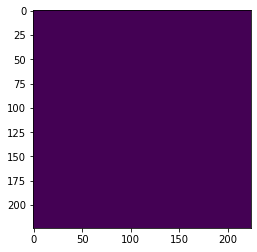

In [25]:
from utils.cam_utils import gradCAM
import torchvision.transforms as tfs

import clip
import torch
from PIL import Image
import numpy as np
import torch.nn.functional as F

clip_model, preprocess = clip.load("RN101", device="cuda")
target = "woman with blonde hair"
target_text = clip.tokenize([target]).cuda()
target_text = clip_model.encode_text(target_text)
img = torch.tensor(a).cuda().permute(2, 0, 1).unsqueeze(0)
# arr = preprocess(img).unsqueeze(0).cuda()

def clip_normalize(img):
    trans = tfs.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    crop = tfs.CenterCrop(224)
    return trans(crop(img))

CAM = gradCAM(clip_model.visual, clip_normalize(img), target_text, clip_model.visual.layer4)
sadboi = np.array(CAM.detach().cpu().squeeze(0).permute(1, 2, 0))
print(sadboi)
plt.figure()
plt.imshow(sadboi)